In [1]:
%matplotlib inline

In [88]:
import os
import pandas as pd
import h5py
import urllib.request
import numpy as np
import sklearn.metrics
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt

import parsl

In [80]:
from aspire import config
parsl.load(config)

In [4]:
num_samples = 1000
chunk_size = 1

In [5]:
def quantile_normalize(df):
    """
    see https://stackoverflow.com/questions/37935920/quantile-normalization-on-pandas-dataframe
    """
    
    rank_mean = df.stack().groupby(df.rank(method='first').stack().astype(int)).mean()
    
    return df.rank(method='min').stack().astype(int).map(rank_mean).unstack()

**Download expression data from archs4**

For more info: https://amp.pharm.mssm.edu/archs4/help.html

In [6]:
url = "https://s3.amazonaws.com/mssm-seq-matrix/human_matrix.h5"
if not os.path.isfile(os.path.basename(url)):
    urllib.request.urlretrieve(url, os.path.basename(url))

In [7]:
file = h5py.File('human_matrix.h5', 'r')

In [8]:
samples = file['meta']['Sample_geo_accession']
tissue = file['meta']['Sample_source_name_ch1']
genes = list(x.decode() for x in file['meta']['genes'])
data = pd.DataFrame(file['data']['expression'][:num_samples], columns=genes) # data has sample rows and gene columns

In [9]:
library = {}
with open('libraries/KEGG_2015.txt') as f:
    for line in f:
        parts = line.strip().split('\t')
        library[parts[0]] = [x.strip() for x in parts[2:]]

In [10]:
# if a gene does not appear in any gene set, the ROC is undefined
# i'm not sure if we should be using sklearn.metrics.roc_auc_score or sklearn.metrics.auc
genes = list(set(sum(library.values(), [])).intersection(genes))

In [11]:
normalized_data = quantile_normalize(data[genes])

In [37]:
@parsl.python_app
def calculate_auc(gene, genes, library, normalized_data):
    import pandas as pd
    import sklearn.metrics
    
    G = pd.DataFrame(index=[gene], columns=library.keys())
    GM = pd.DataFrame(index=[gene], columns=library.keys())
    for gene_set in library:
        intersection = set(library[gene_set] + [gene]).intersection(genes)
        correlation = normalized_data[intersection].corr().loc[gene]
        GM.loc[gene, gene_set] = correlation[correlation.index != gene].mean()
        G.loc[gene, gene_set] = 1 if gene in library[gene_set] else 0
    
    return sklearn.metrics.roc_auc_score(G.loc[gene].values.astype(int), GM.loc[gene].values.astype(float))

In [81]:
auc = []
for gene in tqdm.tqdm_notebook(genes):
    auc += [calculate_auc(gene, genes, library, normalized_data)]    

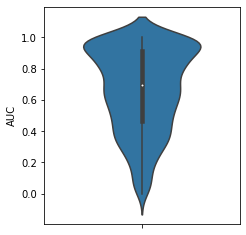

In [79]:
ax = sns.violinplot(x=[i.result() for i in auc], orient='v', width=0.6)
ax.set_ylabel('AUC')
ax.set_aspect(0.8)

In [93]:
print('median AUC: {:.3f}'.format(np.median([i.result() for i in auc])))

median AUC: 0.697


In [91]:
fig = ax.get_figure()
fig.savefig('auc.pdf')